In [1]:
import pandas as pd

route_name_list = ['紅68A','紅68A(延駛大莊里)','紅68B(部分繞駛嘉興國中)','60覺民幹線','60覺民幹線區間車',
                   '橘12(白天延駛澄清湖)','橘11A','橘11B','橘11A區間車','224']

# 時刻表資料
df_sch = pd.read_csv('tdx.csv',index_col=0)
df_sch = df_sch.loc[df_sch['RouteName'].isin(route_name_list)]
df_sch = df_sch[['RouteID','RouteName','Direction','TripID','StopSequence','StopName']]
df_sch = df_sch.groupby(['RouteID','RouteName','Direction']).agg(MinStopSequence=('StopSequence','min'),MaxStopSequence=('StopSequence','max')).reset_index()
df_sch_a = df_sch[['RouteID','RouteName','Direction','MinStopSequence']].rename(columns={'MinStopSequence':'StopSequence'})
df_sch_b = df_sch[['RouteID','RouteName','Direction','MaxStopSequence']].rename(columns={'MaxStopSequence':'StopSequence'})
df_sch = pd.concat([df_sch_a,df_sch_b]).reset_index()

# 調整橘11A站點數
df_sch.loc[23,'StopSequence'] = 58
df_sch.loc[22,'StopSequence'] = 58
# 橘12B
df_sch.loc[32,'StopSequence'] = 57
df_sch.loc[33,'StopSequence'] = 57
# 橘11A區間車
df_sch.loc[34,'StopSequence'] = 54
df_sch.loc[35,'StopSequence'] = 54
display(df_sch)

C:\Users\USER\AppData\Local\Temp\ipykernel_16956\2869338629.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,index,RouteID,RouteName,Direction,StopSequence
0,0,60,60覺民幹線,0,1
1,1,60,60覺民幹線,1,1
2,2,868,紅68A,0,1
3,3,868,紅68A,1,1
4,4,911,橘11A,0,1
5,5,911,橘11A,1,1
6,6,912,橘12(白天延駛澄清湖),0,1
7,7,912,橘12(白天延駛澄清湖),1,1
8,8,6001,60覺民幹線區間車,0,1
9,9,6001,60覺民幹線區間車,1,1


In [2]:
# 公車實際行駛資料
df = pd.read_csv('Schedule_1.csv').reset_index()
df = df.loc[df['RouteName'].isin(route_name_list)]
# 只顯示符合第一站和第n站末站資料


### Three conditions that need to be addressed:
1. Uncompleted route record.
2. Redundant location records at the start/end station.
3. Wrong StopSequence

In [9]:

initialize = 0
plate = df["PlateNumb"].iloc[0]
direction = df["Direction"].iloc[0]
sequence = df["StopSequence"].iloc[0]
for index, row in df.iterrows():
    if row['Direction'] == direction and row['PlateNumb']== plate and row['StopSequence']>=sequence:
        df.at[index,'id'] = initialize
    else:
        initialize+=1
        plate = row["PlateNumb"]
        direction = row["Direction"]
        df.at[index,'id'] = initialize
    sequence = row["StopSequence"]
        

new_df = pd.merge(df,df_sch,left_on=['RouteID','RouteName','StopSequence','Direction'],right_on=['RouteID','RouteName','StopSequence','Direction'],how='right')



In [10]:
new_df = new_df.drop(columns=["Unnamed: 0","ROW#","TRIP_ID"])
start_df = new_df.loc[new_df["StopSequence"]==1].drop_duplicates(subset=["StopSequence","id"],keep="last")
end_df = new_df.loc[new_df["StopSequence"]!=1].drop_duplicates(subset=["StopSequence","id"],keep="first")

result_df = pd.concat([start_df,end_df],ignore_index=True)

In [11]:
# 排除一： 獲取歷史資料時，依GPSTime進行排序，同個班次、路線、站牌的車子前後兩筆資料回傳時間差距過大
tmp = result_df.groupby(['ReportDate','PlateNumb','RouteName','Direction','id']).agg(Max_GPSTime=('GPSTime','max'),Min_GPSTime=('GPSTime','min')).reset_index()

display(tmp)

,ReportDate,PlateNumb,RouteName,Direction,id,Max_GPSTime,Min_GPSTime
0,2023-12-01,705-V2,60覺民幹線,0,2.0,2023-12-01 09:00:47,2023-12-01 09:00:47
1,2023-12-01,705-V2,60覺民幹線,0,4.0,2023-12-01 12:57:08,2023-12-01 11:55:01
2,2023-12-01,705-V2,60覺民幹線,0,6.0,2023-12-01 14:12:29,2023-12-01 14:12:29
3,2023-12-01,705-V2,60覺民幹線,1,3.0,2023-12-01 11:36:32,2023-12-01 10:35:27
4,2023-12-01,705-V2,60覺民幹線,1,5.0,2023-12-01 14:10:39,2023-12-01 13:15:17
...,...,...,...,...,...,...,...
8179,2023-12-31,KKB-8096,紅68B(部分繞駛嘉興國中),1,8650.0,2023-12-31 17:21:04,2023-12-31 17:21:04
8180,2023-12-31,KKB-8096,紅68B(部分繞駛嘉興國中),1,8651.0,2023-12-31 17:36:37,2023-12-31 17:36:37
8181,2023-12-31,KKB-8096,紅68B(部分繞駛嘉興國中),1,8656.0,2023-12-31 18:10:36,2023-12-31 18:10:36
8182,2023-12-31,KKB-8096,紅68B(部分繞駛嘉興國中),1,8658.0,2023-12-31 18:27:12,2023-12-31 18:27:12


In [12]:
from datetime import datetime,timedelta

tmp.loc[:,'TravelTime'] = tmp.apply(lambda x: (datetime.strptime(x['Max_GPSTime'], '%Y-%m-%d %H:%M:%S')
                                         - datetime.strptime(x['Min_GPSTime'],'%Y-%m-%d %H:%M:%S')).total_seconds() / 60,axis=1)
#tmp = pd.merge(tmp,result_df,on=["id"],how='left')
tmp = tmp[['id','Max_GPSTime','Min_GPSTime','TravelTime','ReportDate','PlateNumb','RouteName','Direction']]

In [13]:
tmp = tmp.drop_duplicates(subset=["id"]).reset_index(drop=True)
tmp.drop(tmp[tmp['TravelTime'] == 0].index, inplace = True)
tmp.loc[:,'Min_Schedule_Time'] = tmp.apply(lambda x: datetime.strptime(x['Min_GPSTime'], '%Y-%m-%d %H:%M:%S').strftime('%H:00:00'),axis=1)
tmp.loc[:,'Max_Schedule_Time'] = tmp.apply(lambda x: (datetime.strptime(x['Min_GPSTime'], '%Y-%m-%d %H:%M:%S')+timedelta(hours=1)).strftime('%H:00:00'), axis=1)
tmp.loc[:,'Schedule_Time'] = tmp.apply(lambda x: x['Min_Schedule_Time']+'-'+x['Max_Schedule_Time'],axis=1)
# display(tmp[(tmp["RouteName"]=='橘12(白天延駛澄清湖)')&(tmp["Direction"]==1)])

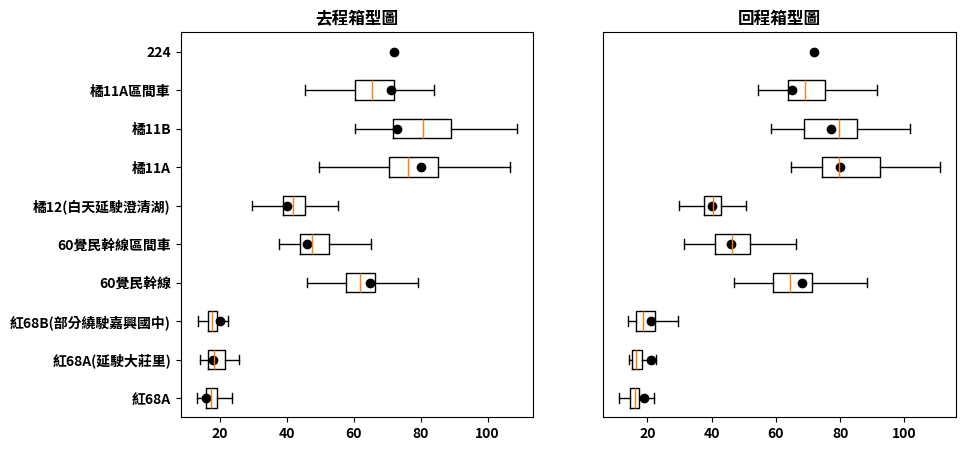

In [14]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib import font_manager

plt.rcParams['font.sans-serif'] = ['Noto Sans TC']
plt.rcParams['axes.unicode_minus']=False

estimate_time = [16,18,20,65,46,40,80,73,71,72]
estimate_time_return = [19,21,21,68,46,40,80,77,65,72]
 
arr = []
arr_return = []
# Creating dataset
for route in route_name_list:
    data_df = tmp.loc[(tmp["Direction"]==0)&(tmp["RouteName"]==route)]
    data_return_df = tmp.loc[(tmp["Direction"]==1)&(tmp["RouteName"]==route)]
    data=data_df["TravelTime"].to_list()
    data_return = data_return_df["TravelTime"].to_list()
    arr.append(data)
    arr_return.append(data_return)


# Creating plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


axes[0].boxplot(arr, 0, '', 0,showbox=True)
for i in range(len(estimate_time)):
    axes[0].plot(estimate_time[i],i+1,color='black', marker='o', markeredgecolor='k')
    axes[1].plot(estimate_time_return[i],i+1,color='black', marker='o', markeredgecolor='k')
axes[0].set_title('去程箱型圖')
axes[0].set_yticks(range(1, 11),route_name_list)
# Plot the second boxplot
axes[1].boxplot(arr_return, 0, '', 0,showbox=True)
axes[1].set_title('回程箱型圖')

axes[1].set_yticks([])
# text(x = fivenum(X), labels = fivenum(X), y = 1.25)


# show plot
plt.show()

<style>
    .white {
        background-color: white;
    }
</style>

<div class="white">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/800px-Boxplot_vs_PDF.svg.png" width="400",height="300">
</div>


In [15]:


quantiles = tmp.groupby(['RouteName','Direction'])['TravelTime'].quantile([0.25, 0.75]).unstack()
# compute interquartile range for each prod
iqr = quantiles.diff(axis=1).bfill(axis=1)
print(quantiles)
# compute fence bounds
fence_bounds = quantiles + iqr * [-1.5, 1.5]
# check if units are outside their respective tukey ranges
tmp['flag'] = tmp.merge(fence_bounds, left_on=['RouteName','Direction'], right_index=True).eval('not (`0.25` < TravelTime < `0.75`)').astype(int)
tmpadjust = tmp.loc[(tmp['flag']==0)]

                               0.25       0.75
RouteName      Direction                      
60覺民幹線         0          57.816667  66.466667
               1          59.070833  71.133333
60覺民幹線區間車      0          43.820833  52.516667
               1          41.029167  51.804167
橘11A           0          70.516667  85.208333
               1          74.233333  92.450000
橘11A區間車        0          60.416667  72.012500
               1          63.808333  75.341667
橘11B           0          71.820833  89.070833
               1          68.800000  85.116667
橘12(白天延駛澄清湖)   0          38.750000  45.383333
               1          37.516667  42.866667
紅68A           0          16.012500  19.141667
               1          14.533333  17.541667
紅68A(延駛大莊里)    0          16.616667  21.400000
               1          15.266667  18.366667
紅68B(部分繞駛嘉興國中) 0          16.500000  19.100000
               1          16.520833  22.475000


In [273]:
time_df = tmpadjust.groupby(['ReportDate','RouteName','Direction','Schedule_Time']).agg(AvgTravelTime=('TravelTime','mean')).reset_index()
                
time_df.loc[:, 'AvgTravelTime'] = time_df.apply(lambda x: float("{:.1f}".format(x['AvgTravelTime'])), axis=1)
time_df = time_df.sort_values(by=['RouteName','ReportDate'])

In [274]:
# time_df.loc[:,'weekday'] = time_df.apply(lambda x:datetime.strptime(x['ReportDate'],'%Y-%m-%d').weekday()+1,axis=1)
# time_df.loc[:,'weekday'] = time_df.apply(lambda x:datetime.strptime(x['ReportDate'],'%Y-%m-%d').weekday()+1,axis=1)
time_df.loc[:,'Week'] = time_df.apply(lambda x:'假日' if pd.Timestamp(x['ReportDate']).weekday() >=5 else '平日',axis=1)

# 計算各路線假日or平日行駛時間
final_df = time_df.groupby(['RouteName','Schedule_Time','Direction','Week'])\
                    .agg(AvgTravelTime=('AvgTravelTime','mean')).reset_index()
final_df.loc[:, 'AvgTravelTime'] = final_df.apply(lambda x: float("{:.1f}".format(x['AvgTravelTime'])), axis=1)
final_df = final_df.pivot(columns='Schedule_Time', values='AvgTravelTime',index=['RouteName','Direction','Week'])
final_result = final_df
final_df = final_df.reset_index()

In [284]:
final_df.to_csv("final.csv",encoding='utf-8-sig')

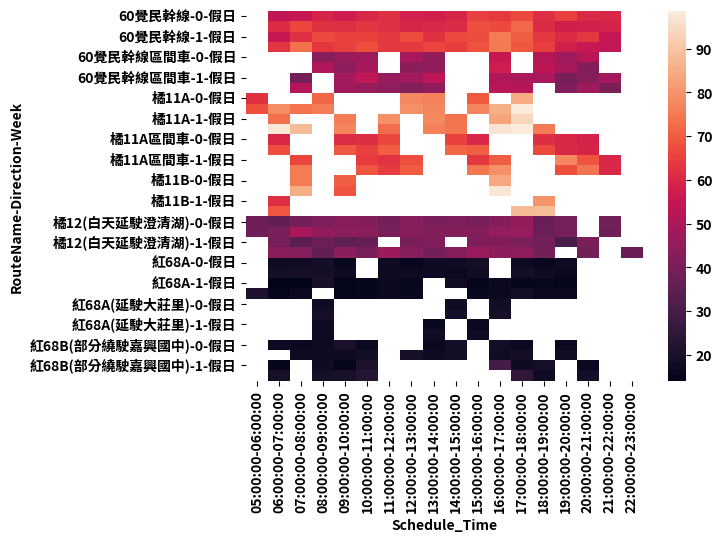

In [276]:
import seaborn as sns

sns.heatmap(final_result)
plt.show()

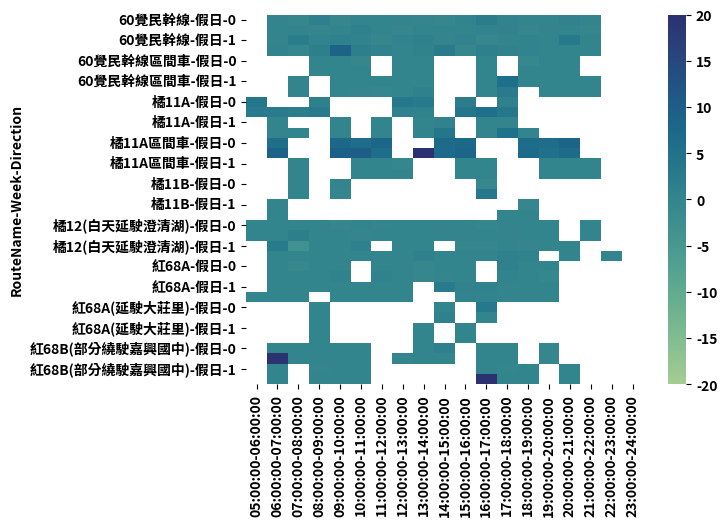

In [283]:
real = pd.read_csv("real.csv")
final_df=final_df.sort_values(by=['RouteName','Direction','Week'])
real=real.sort_values(by=['RouteName','Direction','Week'])
sub_df = real.set_index(['RouteName','Week','Direction']).subtract(final_df.set_index(['RouteName','Week','Direction']), fill_value=0)
sns.heatmap(sub_df,vmin=-20,vmax=20,cmap="crest")
plt.show()